In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2

In [23]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()


Saving archive.zip to archive.zip


In [24]:
import zipfile
import os

# Get the uploaded file name
zip_filename = list(uploaded.keys())[0]  # gets the name of the uploaded file

# Extract it
extract_path = "/content/my_dataset"  # You choose this name

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("After extraction:", os.listdir(extract_path))





After extraction: ['aquarium_pretrain']


In [25]:
TRAIN_PATH = "/content/my_dataset/aquarium_pretrain/train"
VAL_PATH = "/content/my_dataset/aquarium_pretrain/valid"
TEST_PATH = "/content/my_dataset/aquarium_pretrain/test"

TRAIN_LABELS = TRAIN_PATH + "/labels"
VAL_LABELS = VAL_PATH + "/labels"
TEST_LABELS = TEST_PATH + "/labels"

TRAIN_IMAGES = TRAIN_PATH + "/images"
VAL_IMAGES = VAL_PATH + "/images"
TEST_IMAGES = TEST_PATH + "/images"


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [27]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


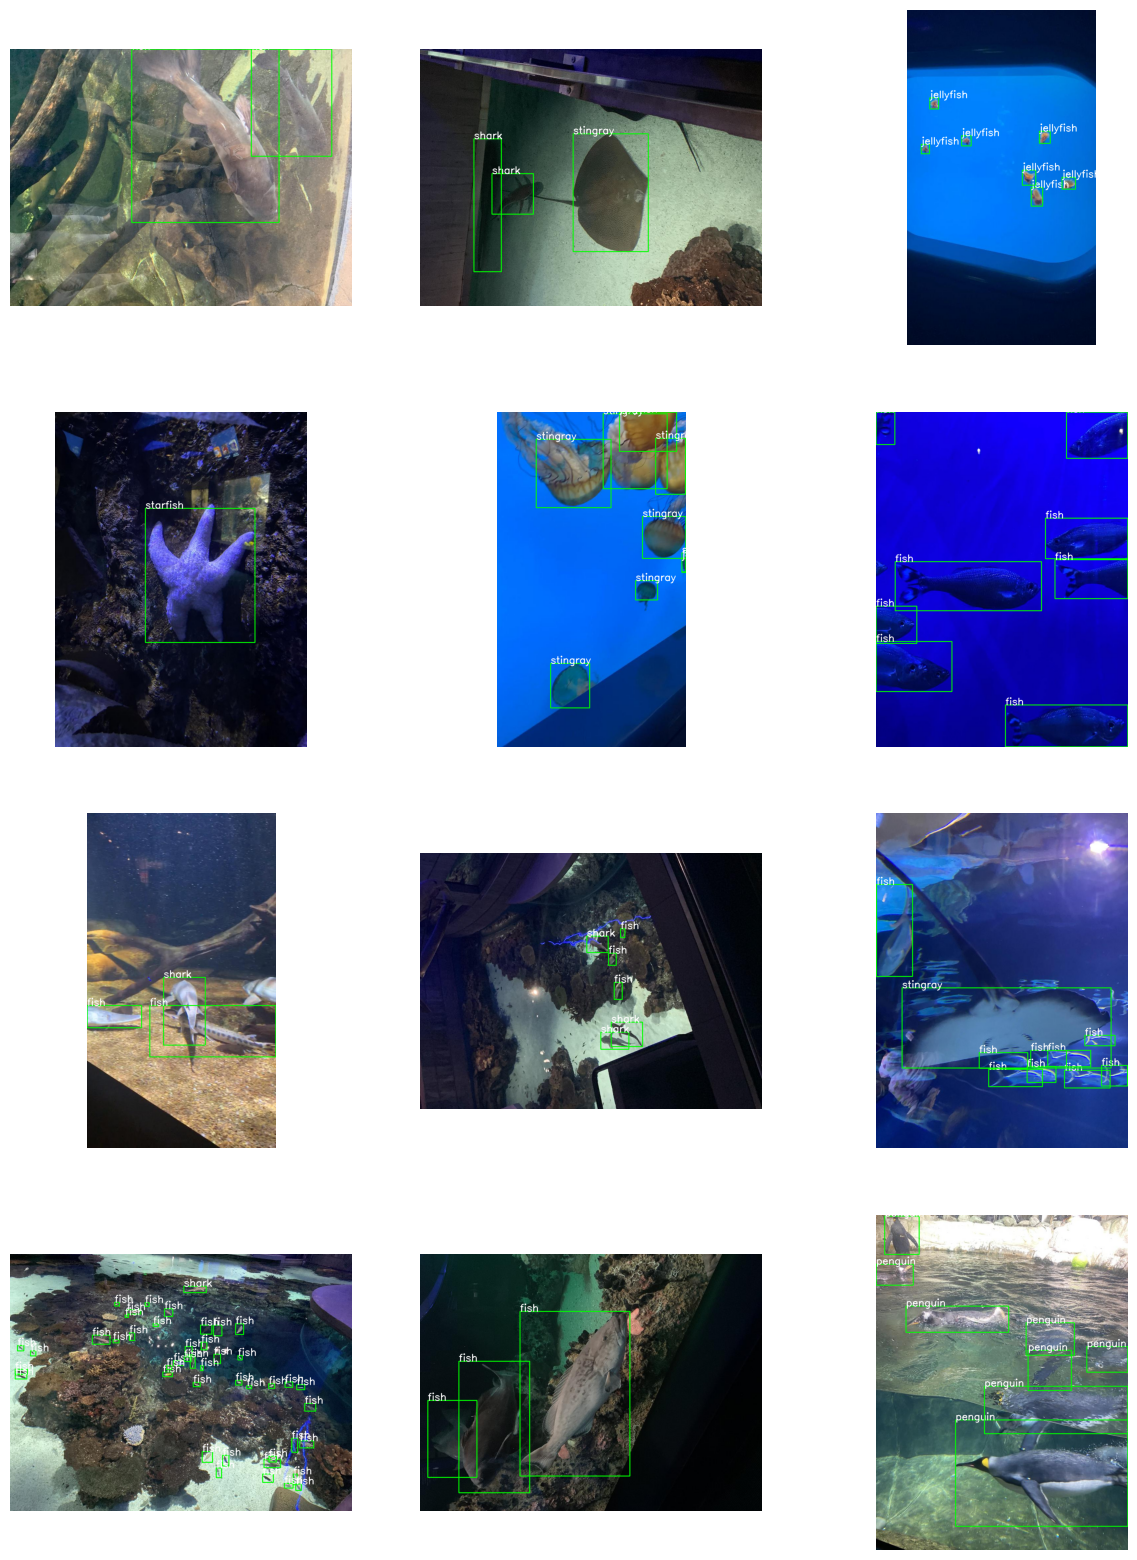

In [28]:
def visualize_image_with_annotation_bounding_boxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                image,
                Idx2Label[int(class_id)],
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()


visualize_image_with_annotation_bounding_boxes(TRAIN_IMAGES, TRAIN_LABELS)